In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd

from typing import *

In [2]:
from nepal.datasets import NYTimes
from nepal.ml.preprocess import Cases

df: pd.DataFrame = Cases(NYTimes()).preprocessed()

In [4]:
import warnings

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape

from nepal.ml.forecaster import BaseForecaster
from nepal.ml.splitter import Splitter


def cross_validate(
    forecaster: BaseForecaster,
    *,
    splitter: Splitter,
    y: pd.DataFrame,
    Xs: Optional[Iterable[pd.DataFrame]] = None,
) -> Sequence[float]:
    scores: List[float] = []
    for df_train, df_test in splitter.train_test_splits(y=y):
        model = forecaster.fit(y=df_train, Xs=Xs)
        df_pred = model.forecast(fh=splitter.fh, y=df_train, Xs=Xs)

        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            score: float = mape(y_true=df_test, y_pred=df_pred, symmetric=True)
            scores.append(score)

    return scores

In [5]:
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=60, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)

scores: Sequence[float] = cross_validate(forecaster, splitter=splitter, y=df[["new_cases"]])
print(np.mean(scores))

Train/Test split:   0%|          | 0/13 [00:00<?, ?it/s]

1.1961088902660946


<AxesSubplot:>

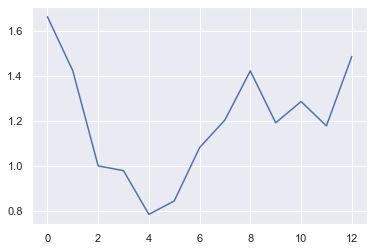

In [6]:
import seaborn as sns

sns.set(style="darkgrid")
sns.lineplot(data=scores)

In [ ]:
import optuna


def objective(trial: optuna.Trial) -> float:
    lag = trial.suggest_int("lag", 2, 30)
    forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=lag)

    scores: Sequence[float] = cross_validate(forecaster, splitter=splitter, y=df[["new_cases"]])
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

study.best_params  # Best found lag value with default LGBM params: 9

In [7]:
from nepal.graph import Connection, LocalConnection, GraphDB

conn: Connection = LocalConnection(
    database="neo4j",
    password="corona",
)

assert conn.is_up()

In [ ]:
import optuna
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

from nepal.graph.gds import CountyEmbedding


embedding = CountyEmbedding()
fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)


def objective(trial: optuna.Trial) -> float:
    forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)

    X: pd.DataFrame = embedding.load_dataframe(
        connection=conn,
        embedding_dimension=trial.suggest_int("dim", 8, 512, log=True),
        weight2=trial.suggest_float("weight2", 0.0, 1.0),
        weight3=trial.suggest_float("weight3", 0.0, 1.0),
        weight4=trial.suggest_float("weight4", 0.0, 1.0),
        normalization=trial.suggest_float("normalization", -1.0, 1.0),
        property_ratio=trial.suggest_float("prop_ratio", 0.0, 1.0),
        self_influence=trial.suggest_float("self_influence", 0.0, 1.0),
    ).rename(index={"fips": "FIPS"})

    scores: Sequence[float] = cross_validate(
        forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[X]
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params  # Best found lag value with default LGBM params: 13

[I 2022-05-31 22:25:57,580] A new study created in memory with name: no-name-fab83e15-8fb9-4679-95c8-66995da820da


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]